In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra, Plots
import MeshCat as mc 
using Test
using Random
import ForwardDiff as FD     


  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`


In [2]:
#include(joinpath(@__DIR__,"ref_traj.jl"))
#include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))
#include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v2.jl"))
include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v3.jl"))


animate_hexrotor (generic function with 1 method)

In [3]:
# function create_ref_hover(model, N, dt, n_inputs)
#     # create a hover reference (with no pitch) for whole time period
#     mass = model.mass
#     kf = model.kf

#     # hover altitude
#     desired_altitude= 1

#     # hover state
#     hover_position = [0.0; 0.0; desired_altitude]  # Hover at (0, 0, 5)
#     hover_velocity = [0.0; 0.0; 0.0]  # no velocity
#     hover_attitude = [0.0; 0.0; 0.0]  # No roll, pitch, yaw
#     hover_angvelocity= [0.0; 0.0; 0.0] # no angular velocity
    
#     Xref= [zeros(12) for i = 1:N]
#     for i= 1:N
#         Xref[i]= [hover_position; hover_velocity; hover_attitude; hover_angvelocity]
#     end

#     #Uref = [(9.81*mass/(n_inputs*kf))*ones(n_inputs) for i = 1:(N-1)]
#     Uref = [(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)]
#     return Xref, Uref
# end


# converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end


mat_from_vec (generic function with 1 method)

In [4]:
"
Determining the equilibrium point for controls at hover
    - use Newton's method (minimize over u for least squares cost)
    - initial guess= hover location for planar hexarotor ([(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)])
" 

function controls_equilibrium(u0::Vector, X̄, model, ode; tol= 1e-6, max_iters= 100, verbose= false)::Vector{Vector{Float64}}

    # initialize U
    U = [zeros(eltype(u0), length(u0)) for i= 1:max_iters] #empty vector for Newton guesses
    U[1]= u0 #initialize with first guess (which is simply counteracting gravity (mg/n_inputs)

    for i = (1:max_iters-1)
        
        residual= (1/2) * (ode(model, X̄, U[i]))'* ode(model, X̄, U[i]) # least squares cost function
        δfδu= FD.jacobian(du -> ode(model, X̄, du), U[i]) # jacobian of f with respect to u

        ∇residual= (δfδu)' * ode(model, X̄, U[i]) # gradient of cost function- to solve for u, this should be zero
        ∇²residual= ((δfδu)' * δfδu) + 1e-3*(I(6)) # hessian (gauss newton version) of cost function 
        # regularization term to ensure full rank
        #println("rank hessian: ", rank(∇²residual))

        norm_residual= norm(residual)

        if verbose 
            print("iter: $i    |residual|: $norm_residual   \n")
        end

        # check against tol
        # if converged, return U[1:i]
        if norm_residual < tol
            return U[1:i]
        end

        Δu= ∇²residual\(-∇residual) # Newton step
        #println(Δu)

        # update U
        U[i+1]= U[i] + vec(Δu)
        #println(U[i+1])
    end
    error("Newton's method did not converge")
end

controls_equilibrium (generic function with 1 method)

In [5]:
" Other notes
    - Frequency for drone should be much faster (at least 50-100 Hz)
    - noise can be sampled at a lower frequency 
    - use newton's method to determine the hover equilibrium point for linearization 


notes on how I made Newton's converge
    - added a regularization term to the hessian. is that ok or is that cheating? lol
    - tuning kf

"

" Other notes\n    - Frequency for drone should be much faster (at least 50-100 Hz)\n    - noise can be sampled at a lower frequency \n    - use newton's method to determine the hover equilibrium point for linearization \n\n\nnotes on how I made Newton's converge\n    - added a regularization term to the hessian. is that ok or is that cheating? lol\n    - tuning kf\n\n"

In [6]:
# Drone model parameters
Ixx= 2.331e2 
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), #inertia matrix- determined from CAD
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 13, # constant thrust coefficient- this was guessed based on the quadrotor dynamics (linear relationship based on mass...)
    km= 0.0245, # propeller drag coefficient (0.0245 for quadrotor (0.5kg)
    dt= 0.01, # frequency
    α= 0.49, # radians
    β= 0.33 # radians
)

# problem size 
nx = 12 # number of states
nu = 6 # number of controls
dt = model.dt
tf = 20
t_vec = 0:dt:tf
N = length(t_vec)
m= model.mass
kf= model.kf


################# NEWTON METHOD STUFF to find the controls equilibrium point
# hover state
X̄= [0.0; 0.0; 3.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
# initial guess for control equilibrium point- I made this the hover thrust for the planar hexrotor
u0= [(9.81*m/nu); (9.81*m/nu); (9.81*m/nu); (9.81*m/nu); (9.81*m/nu); (9.81*m/nu)] 

U= controls_equilibrium(u0, X̄, model, hexrotor_dynamics, tol= 1e-6, max_iters= 100, verbose= true)

# double check convergence of the cost function 
@test norm((1/2) * (hexrotor_dynamics(model, X̄, U[end]))'* hexrotor_dynamics(model, X̄, U[end])) < 1e-3

Ū= U[end] # control equilibrium point! will linearize around this point
println("U equilibrium point= ", Ū)
######################################

#### cost terms 
Q = diagm([100,100,100,
1,1,1,
100,100,100,
1,1,1])

Qf = 10*Q

R = 0.001*diagm(ones(nu))

# check the norm of the nonlinear disretized dynamics to make sure they match at the equilibrium point
println("norm between X̄ and discretized dynamics= ", norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, dt)))
@assert norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, dt)) < 1e-3


# calculate A and B matrices (jacobians of discrete dynamics with respect to X̄ and Ū)
A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ū, dt), X̄)
B= FD.jacobian(du -> rk4(model, hexrotor_dynamics, X̄, du, dt), Ū)

# infinite horizon LQR- will use steady state P as the Qn for the MPC controller
Kinf= B'
max_iters= 1e6
P= deepcopy(Q) #initialize p
for i= 1:max_iters
    Kinf = (R .+ B' * P * B)\  (B' * P * A)
    P_recursion = Q + A' * P * A - A' * P * B * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end 
    # update P for next iteration
    P = 1*P_recursion
end

iter: 1    |residual|: 4943.863490868141   
iter: 2    |residual|: 0.0001854186988044426   
iter: 3    |residual|: 3.87107967552756e-5   
iter: 4    |residual|: 8.973259090488915e-6   
iter: 5    |residual|: 2.0805143487378375e-6   


iter: 6    |residual|: 4.827035616585645e-7   
U equilibrium point= 

[1.5253436934647195, 0.011544191176242617, 1.5073484753462068, 1.5084352860940295, 0.005380240727046896, 1.5242565739110603]


norm between X̄ and discretized dynamics= 9.825532434454266e-6


In [7]:
############# varying noise frequency test block- I am still working on this :)
# using Interpolations

# # Parameters
# t_start = 0.0   # Start time of simulation
# t_end = 10.0    # End time of simulation
# dt_simulation = 0.1  # Discretization time step of simulation
# noise_frequency = 0.01  # Frequency of noise (lower than simulation frequency)

# # Generate noise signal
# t_noise = collect(t_start:dt_simulation:noise_frequency*t_end)
# noise_signal = randn(length(t_noise))

# # Interpolate noise signal to match simulation time points
# interp_noise = LinearInterpolation(t_noise, noise_signal)

# # Generate initial conditions
# initial_conditions = ...  # Define your initial conditions here

# # Add noise to initial conditions
# noisy_initial_conditions = initial_conditions .+ interp_noise(t_start)

# # Use noisy initial conditions for simulation


In [11]:
# wind stuff 

function update_wind(current_wind, dt, intensity)
    # Random walk update
    d_wind = randn(size(current_wind)) .* sqrt(intensity * dt)
    new_wind = current_wind + d_wind
    return new_wind
end

# Initialize wind parameters
wind_dynamics = zeros(nx, 3)
wind_dynamics[4, 1] = 1  # Wind effect on vx
wind_dynamics[5, 2] = 1  # Wind effect on vy
wind_dynamics[6, 3] = 1  # Wind effect on vz
wind_velocity = [0.5, 0, 0] # Intensity of the turbulence
wind_intensity = 0.5

0.5

In [24]:
Random.seed!(1) 

# I determined these experimentally
u_min= -100
u_max= 100

Xsim= [zeros(nx) for i = 1:N]
Usim= [zeros(nu) for i = 1:N-1]

x0= 1*X̄ # initialize the simulation with X̄

Xsim[1] = x0 + 0.1* randn(nx) # add a little bit of noise...
for i = 1:N-1
    # calculate target control offset
    Utarget = -B\((A - I(nx)) * X̄ + wind_dynamics * wind_velocity)
    # calculate control inputs
    # Usim[i]= clamp.(-Kinf * (Xsim[i]-X̄) +Utarget +0.1* randn(nu), u_min, u_max)
    Usim[i]= clamp.(-Kinf * (Xsim[i]-X̄) +Ū +0.1* randn(nu), u_min, u_max)
    # Usim[i]= clamp.(-Kinf * (Xsim[i]-X̄) +Utarget, u_min, u_max)

    # simulate the system with nonlinear dynamics
    # Xsim[i+1]= rk4(model, hexrotor_dynamics,(Xsim[i]+0.001* randn(nx)), Usim[i], dt)
    Xsim[i+1]= rk4(model, hexrotor_dynamics,(Xsim[i]), Usim[i], dt) + wind_dynamics*wind_velocity

    #Δx[i+1]= A*(Δx[i]) + B*(Δu[i]) #+ 0.01* randn(nx)
    
end

# check for stability
eig= abs.(eigvals(A- B*Kinf))
# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end
println(eig)


The system is stable.
[0.29969121075027694, 0.5680166677982509, 0.6163787147571599, 0.9028142329180526, 0.9033608813306218, 0.904483553080872, 0.9886796911617033, 0.9886796911617033, 0.9891260789917277, 0.9891260789917277, 0.993409677870782, 0.993409677870782]


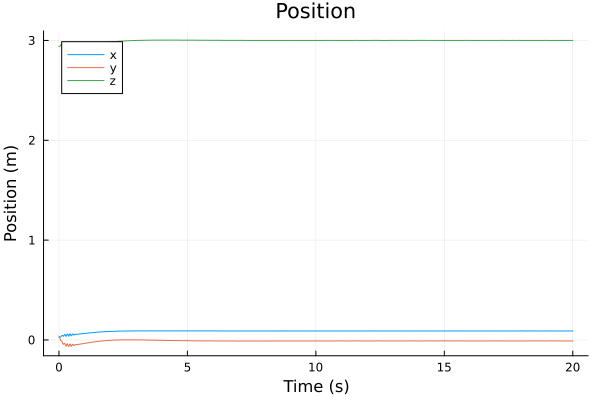

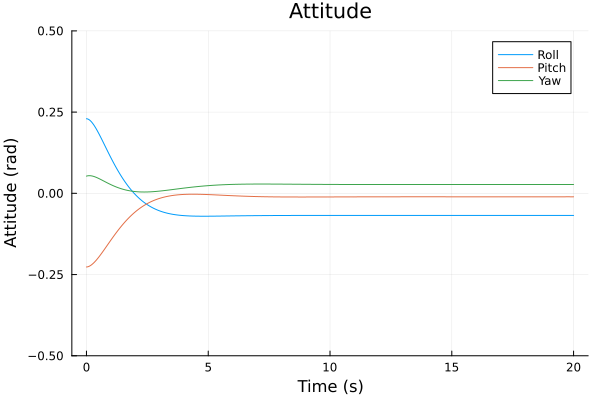

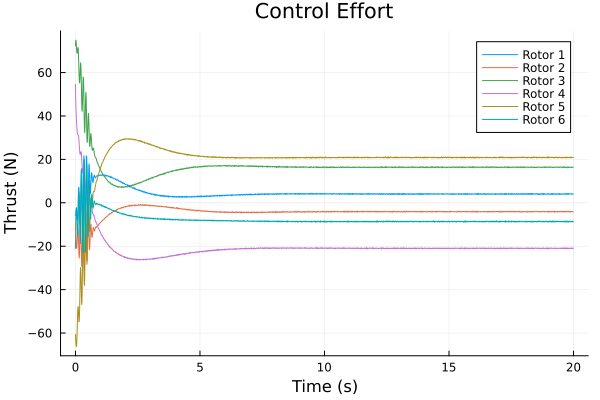

┌ Info: Listening on: 127.0.0.1:8706, thread id: 1
└ @ HTTP.Servers C:\Users\scott\.julia\packages\HTTP\bDoga\src\Servers.jl:367
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8706
└ @ MeshCat C:\Users\scott\.julia\packages\MeshCat\I6NTX\src\visualizer.jl:63


SystemError: SystemError: opening file "c:\\Users\\scott\\Documents\\OCRL\\MPCwZAC\\hexarotor_tilted_props.obj": No such file or directory

In [25]:
    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(Xsim)
    Um = mat_from_vec(Usim)
  
    display(plot(t_vec,Xm[1:3,:]',title = "Position",
            xlabel = "Time (s)", ylabel = "Position (m)",
            label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[7:9,:]', title = "Attitude",
            xlabel = "Time (s)", ylabel = "Attitude (rad)", ylimits=(-0.5,0.5),
            label = ["Roll" "Pitch" "Yaw"])) 
    display(plot(t_vec[1:end-1],Um',title = "Control Effort",
            xlabel = "Time (s)", ylabel= "Thrust (N)", label= ["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))  

# mesh cat display
display(animate_hexrotor(Xsim, dt))